In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#----------- Binary Classification -----------

In [ ]:
# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
def calculate_class_weights(labels):
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(class_weights))

In [ ]:
malaria_ds, info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True)
train_ds = malaria_ds['train']

**Data Preprocessing**

In [ ]:
def preprocess_binary(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    label = tf.cast(label, tf.float32)
    return image, label

In [ ]:
binary_train_ds = train_ds.take(int(len(train_ds) * 0.8)).map(preprocess_binary).shuffle(1000).batch(BATCH_SIZE)
binary_val_ds = train_ds.skip(int(len(train_ds) * 0.8)).map(preprocess_binary).batch(BATCH_SIZE)

binary_labels = [label.numpy() for _, label in train_ds.map(preprocess_binary)]
binary_class_weights = calculate_class_weights(binary_labels)

**Deep CNN for binary classification**

In [ ]:

binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Tranning Stage**

In [ ]:
binary_model.fit(
    binary_train_ds,
    validation_data=binary_val_ds,
    epochs=10,
    class_weight=binary_class_weights
)

In [ ]:
binary_model.save('deep_binary_classification_model.h5')
print("Deep CNN models trained and saved successfully!")

In [ ]:
binary_model = tf.keras.models.load_model('deep_binary_classification_model.h5')

# Visualization Function
def visualize_predictions(model, dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    images, labels = next(iter(dataset))
    predictions = model.predict(images[:num_images])

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].numpy())
        pred_label = "Positive" if predictions[i] > 0.5 else "Negative"
        true_label = "Positive" if labels[i] == 1 else "Negative"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocessing Function
def preprocess_for_visualization(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    return image, label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


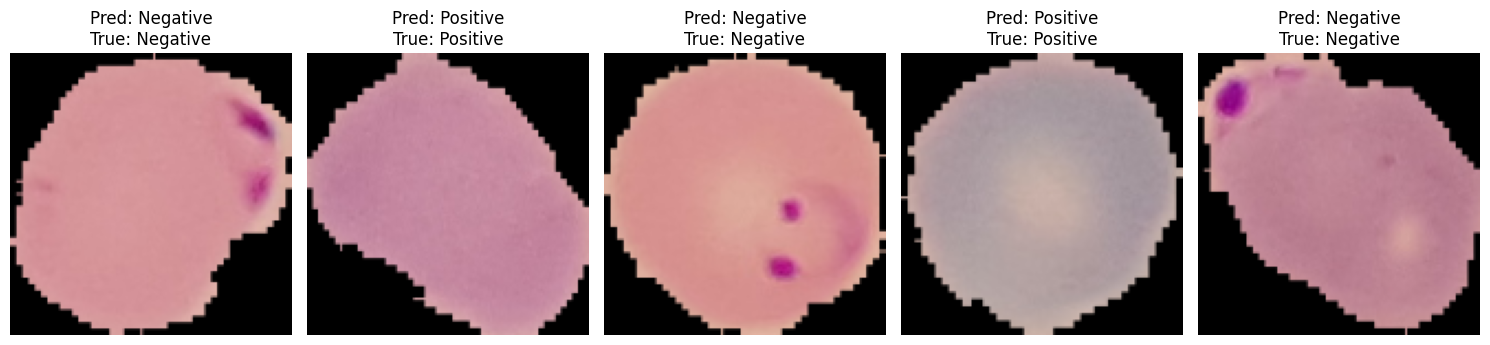

In [ ]:
# Load and Prepare Dataset
malaria_ds = tfds.load('malaria', as_supervised=True, shuffle_files=False)
binary_test_ds = malaria_ds['train'].skip(int(len(malaria_ds['train']) * 0.8)).map(preprocess_for_visualization).batch(BATCH_SIZE)

# Visualize Predictions
visualize_predictions(binary_model, binary_test_ds)

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_metrics(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int).flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    return y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━

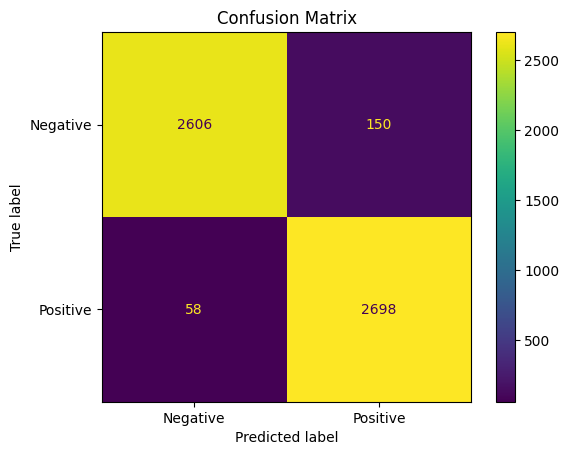

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

y_true, y_pred = compute_metrics(binary_model, binary_test_ds)
plot_confusion_matrix(y_true, y_pred)

#----------- Multiclass Classification -----------

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
MULTICLASS_DATASET_PATH = '/content/drive/MyDrive/MalariaSD copy/MalariaSD/final_dataset'

 **Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_gen = datagen.flow_from_directory(
    MULTICLASS_DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 640 images belonging to 16 classes.


In [ ]:
val_gen = datagen.flow_from_directory(
    MULTICLASS_DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 159 images belonging to 16 classes.


**Transfer Learning Model (MobileNetV2)**

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Custom Model Head
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

**Tranning Stage**

In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 803ms/step - accuracy: 0.2287 - loss: 6.2433 - val_accuracy: 0.5346 - val_loss: 1.3471 - learning_rate: 0.0010
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.5565 - loss: 1.4931 - val_accuracy: 0.6730 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 746ms/step - accuracy: 0.6241 - loss: 1.1364 - val_accuracy: 0.6981 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 722ms/step - accuracy: 0.7164 - loss: 0.9403 - val_accuracy: 0.7296 - val_loss: 0.8764 - learning_rate: 0.0010
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 728ms/step - accuracy: 0.7006 - loss: 0.8878 - val_accuracy: 0.7987 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.7519 - loss: 0.8325 - val_accuracy: 0.8113 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 740ms/step - accuracy: 0.7468 - loss: 0.7760 - val_

In [ ]:
model.save('transfer_learning_model.h5')

print("Transfer learning model trained and saved successfully!")

In [ ]:
model = tf.keras.models.load_model('transfer_learning_model.h5')
def plot_training_history(history):
    plt.figure(figsize=(12, 12))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_metrics(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys()))

    return y_true, y_pred_classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step

Classification Report:
                         precision    recall  f1-score   support

 falciparum_gametocyte       1.00      0.30      0.46        10
       falciparum_ring       0.91      1.00      0.95        10
   falciparum_schizont       1.00      1.00      1.00         9
falciparum_tropohzoite       0.83      1.00      0.91        10
    malarae_gametocyte       0.67      1.00      0.80        10
          malarae_ring       1.00      0.60      0.75        10
      malarae_schizont       0.88      0.70      0.78        10
   malarae_trophozoite       0.91      1.00      0.95        10
      ovale_gametocyte       1.00      1.00      1.00        10
            ovale_ring       1.00      1.00      1.00        10
        ovale_schizont       0.90      0.90      0.90        10
     ovale_trophozoite       1.00      0.90      0.95        10
      vivax_gametocyte       0.83      1.00      0.91        10
            vivax_ring       0.91      

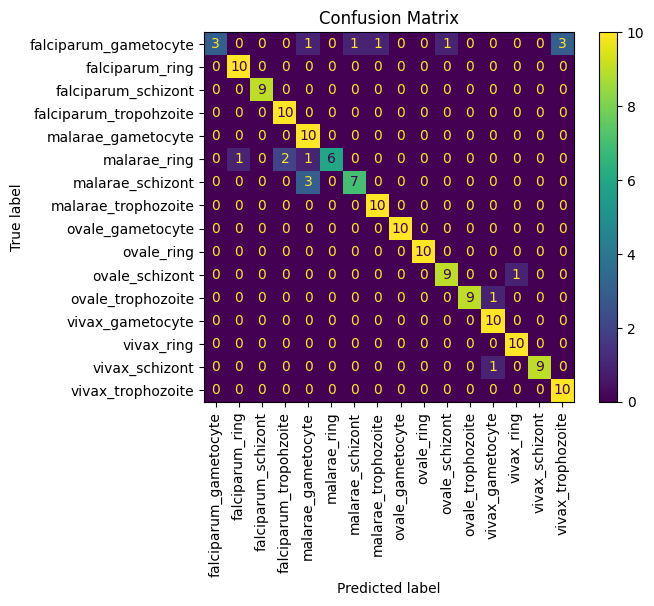

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

y_true, y_pred_classes = compute_metrics(model, val_gen)
plot_confusion_matrix(y_true, y_pred_classes, class_names=list(val_gen.class_indices.keys()))

**TESTING STAGE**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_SIZE = (128, 128)
binary_model = tf.keras.models.load_model('/content/deep_binary_classification_model.h5')
multiclass_model = tf.keras.models.load_model('/content/transfer_learning_model.h5')


multiclass_labels = [
    "falciparum_gametocyte", "falciparum_ring", "falciparum_schizont", "falciparum_trophozoite",
    "malarae_gametocyte", "malarae_ring", "malarae_schizont", "malarae_trophozoite",
    "ovale_gametocyte", "ovale_ring", "ovale_schizont", "ovale_trophozoite",
    "vivax_gametocyte", "vivax_ring", "vivax_schizont", "vivax_trophozoite"
]


def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def predict_image(image_path):
    img_array = preprocess_image(image_path)
    binary_prediction = binary_model.predict(img_array)
    if binary_prediction[0] > 0.5:
        print(f"Binary Prediction: Uninfected (Confidence: {binary_prediction[0][0]:.2f})")
        return "Uninfected"
    else:
        print(f"Binary Prediction: Parasitized (Confidence: {1 - binary_prediction[0][0]:.2f})")
        multiclass_prediction = multiclass_model.predict(img_array)
        predicted_class = np.argmax(multiclass_prediction, axis=1)[0]
        confidence = multiclass_prediction[0][predicted_class]
        print(f"Multiclass Prediction: {multiclass_labels[predicted_class]} (Confidence: {confidence:.2f})")
        return multiclass_labels[predicted_class]


unseen_image_path = "/content/C98P59ThinF_IMG_20150917_154452_cell_19.png"
result = predict_image(unseen_image_path)

print(f"Final Prediction: {result}")

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 128, 128, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']